### Interpret Results: 2D Classification

#### Imports and Helper Functions

In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_parent_dir_path, set_plot_style

modify_sys_path()
set_plot_style()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage import zoom
import colorsys

from src.utils import calculate_min_Va_by_KL_rank

In [3]:

def get_results_df_and_feature_cols(results_directory, num_classes: int, num_valid_Va: int=5):
    prob_labels = list(range(num_classes))
    
    # Load the results
    D_data = None
    for filename in os.listdir(get_parent_dir_path(results_directory)):
        if f"D_" in filename:
            D_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
            
    df_list = []
    for filename in os.listdir(get_parent_dir_path(results_directory)):
        if f"results_" in filename:
            save_data = pd.read_csv(get_parent_dir_path(results_directory) + filename)
            df_list.append(save_data)
    for save_data in df_list:
        save_data = calculate_min_Va_by_KL_rank(save_data, num_valid_Va=num_valid_Va, forward_kl=True)
    feature_columns = [col for col in D_data.columns if col != 'label' and col != 'note']

    x_feature_list = []
    total_uncertainty_list = []
    kl_pyx_pyxz_list = []
    kl_pyxz_pyx_list = []
    min_Va_list = []    
    max_Ve_list = []
    z_value_for_min_Va_list = []

    prob_y_xz_list = []
    prob_y_x_list = []
    within_threshold_list = []


    for z_df in df_list:
        try:
            x_feature_list.append([z_df[f'x_{col}'].values[0] for col in feature_columns])
            min_Va = z_df["H[p(y|x,D)]"].values[0]
            total_uncertainty_list.append(min_Va)
            prob_y_xz = {}
            prob_y_x = {}
            # index where z_value_for_min_Va is True
            min_Va_index = z_df[z_df["z_value_for_min_Va"]].index[0]
            z_value_for_min_Va_list.append([z_df[f"z_{col}"].values[min_Va_index] for col in feature_columns])
            for label in prob_labels:
                prob_y_xz[label] = z_df[f"p(y={label}|x,z,D)"].values[min_Va_index]
                prob_y_x[label] = z_df[f"p(y={label}|x,D)"].values[min_Va_index]
            prob_y_xz_list.append(prob_y_xz)
            prob_y_x_list.append(prob_y_x)
            kl_pyx_pyxz = z_df["kl_pyx_pyxz"].values[min_Va_index]
            kl_pyx_pyxz_list.append(kl_pyx_pyxz)
            kl_pyxz_pyx = z_df["kl_pyxz_pyx"].values[min_Va_index]
            kl_pyxz_pyx_list.append(kl_pyxz_pyx)
            min_Va = z_df["min_Va"].values[0]
            min_Va_list.append(min_Va)
            max_Ve = z_df["max_Ve"].values[0]
            max_Ve_list.append(max_Ve)
            
            within_threshold_list.append([z_df[z_df["within_threshold"]][f"z_{col}"].values for col in feature_columns])
            
        except:
            pass
        
    # Create a dataframe from the lists
    data = {
            'total_uncertainty': total_uncertainty_list,
            'min_Va': min_Va_list,
            'max_Ve': max_Ve_list,
            'kl_pyx_pyxz': kl_pyx_pyxz_list,
            'kl_pyxz_pyx': kl_pyxz_pyx_list,
            # 'z_value_for_min_Va': z_value_for_min_Va_list,
            # 'within_threshold': within_threshold_list
            }

    data = {**{f"x_{col}": [d[i] for d in x_feature_list] for i, col in enumerate(feature_columns)}, **data}

    data = {**data, **{f"z_{col}": [d[i] for d in z_value_for_min_Va_list] for i, col in enumerate(feature_columns)}}

    data = {**data, **{f"within_threshold_{col}": [d[i] for d in within_threshold_list] for i, col in enumerate(feature_columns)}}

    for label in prob_labels:
        data[f"p(y={label}|x,z,D)"] = [d[label] for d in prob_y_xz_list]
        data[f"p(y={label}|x,D)"] = [d[label] for d in prob_y_x_list]

    num_Va = len(min_Va_list)

    # reduce the length of list to the number of num_Va
    for key in data.keys():
        data[key] = data[key][:num_Va]

    results_df = pd.DataFrame(data)

    results_df = results_df.sort_values(by=[f"x_{col}" for col in feature_columns])

    return results_df, D_data, feature_columns

In [4]:
def get_figure_ticks_and_extents(feature_columns, results_df: pd.DataFrame):
    feature_lengths = [len(results_df[f"x_{col}"].unique()) for col in feature_columns]

    feature_values = [results_df[f"x_{col}"].unique() for col in feature_columns]
    
    feature_ranges = []

    for i, feature in enumerate(feature_columns):
        feature_ranges.append((feature_values[i][0], feature_values[i][-1]))
        
    feature_ranges = np.array(feature_ranges)
    
    feature_increment = np.round([feature_values[i][1] - feature_values[i][0] for i in range(len(feature_columns))],2)
    
    extents = np.round([feature_ranges[i][0] - feature_increment[i] for i in range(len(feature_columns))] + [feature_ranges[i][1] + feature_increment[i] for i in range(len(feature_columns))],3)
    extents = extents.reshape((2,len(feature_columns)))
    extents = extents.T
    extents = extents.flatten()
    
    return feature_lengths, extents

In [5]:
def brighter_colour(colour, amount=0.5):
    rgb = mpl.colors.to_rgb(colour)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # l = min(1, l + amount)
    s = min(1, s + amount)
    new_rgb = colorsys.hls_to_rgb(h, l, s)
    return mpl.colors.to_hex(new_rgb)

In [6]:
def colour_combine(probability: np.ndarray, rgb: np.ndarray) -> np.ndarray:
    """
    Combine the probability with the RGB colour.
    """
    return np.stack(np.array([probability * color for color in rgb]), axis=-1)

### Parameters (EDIT HERE)

In [7]:
RESULTS_DIRECTORY = f'results/toy_classification/spirals/experiment_1/'

NUMBER_OF_CLASSES = 3

ZOOM_LEVEL = 4

### Decomposition Plots

In [8]:
results_df, D_data, feature_columns = get_results_df_and_feature_cols(RESULTS_DIRECTORY, NUMBER_OF_CLASSES, num_valid_Va=5)

In [9]:
feature_lengths, extents = get_figure_ticks_and_extents(feature_columns, results_df)

##### Total Uncertainty Heatmap

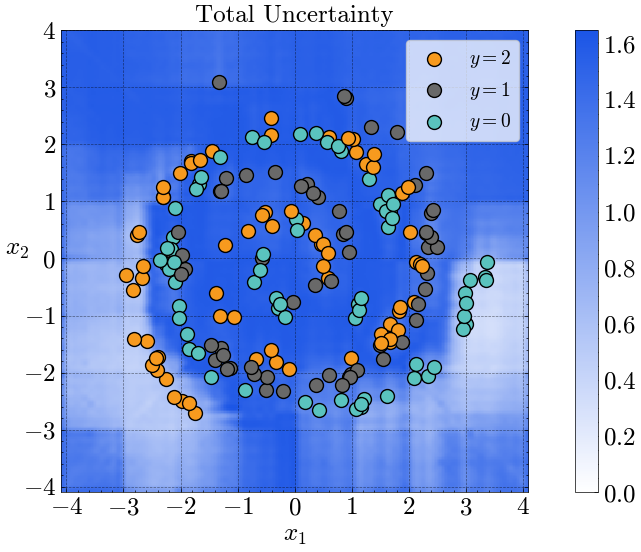

In [10]:
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('white_to_C0', ['white', brighter_colour('C0',0.3)])

fig, ax = plt.subplots(figsize=(12, 6))
total_uncertainty = results_df["total_uncertainty"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(total_uncertainty, ZOOM_LEVEL), origin="lower", extent=extents ,cmap=custom_cmap, vmin=0)

cbar = fig.colorbar(cax)

ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$", rotation=0)
ax.set_title("Total Uncertainty")

label_0_seen = False
label_1_seen = False
label_2_seen = False
for i, row in D_data.iterrows():

    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'$y=0$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C2', edgecolor='black', s=100, alpha=1, label=label_string)
    if row['label'] == 1:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'$y=1$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C3', edgecolor='black', s=100, alpha=1, label=label_string)
    if row['label'] == 2:
        if not label_2_seen:
            label_2_seen = True
            label_string = r'$y=2$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C4', edgecolor='black', s=100, alpha=1, label=label_string)
        
ax.legend(framealpha=0.75)


##### Aleatoric Uncertainty Heatmap

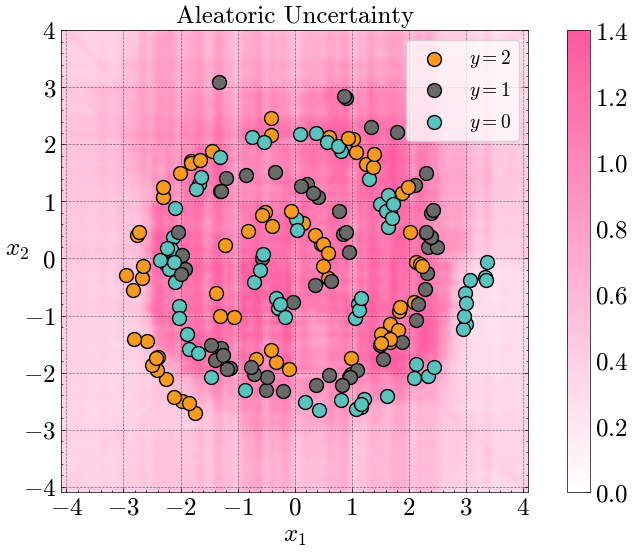

In [11]:
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('white_to_C1', ['white', brighter_colour('C1',0.3)])

fig, ax = plt.subplots(figsize=(10, 6))
min_Va = results_df["min_Va"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(min_Va, ZOOM_LEVEL), origin="lower", extent=extents ,cmap=custom_cmap, vmin=0)
cbar = fig.colorbar(cax)

ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$", rotation=0)
ax.set_title("Aleatoric Uncertainty")

label_0_seen = False
label_1_seen = False
label_2_seen = False
for i, row in D_data.iterrows():

    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'$y=0$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C2', edgecolor='black', s=100, alpha=1, label=label_string)
    if row['label'] == 1:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'$y=1$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C3', edgecolor='black', s=100, alpha=1, label=label_string)
    if row['label'] == 2:
        if not label_2_seen:
            label_2_seen = True
            label_string = r'$y=2$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C4', edgecolor='black', s=100, alpha=1, label=label_string)
ax.legend(framealpha=0.75)


##### Epistemic Uncertainty Heatmap

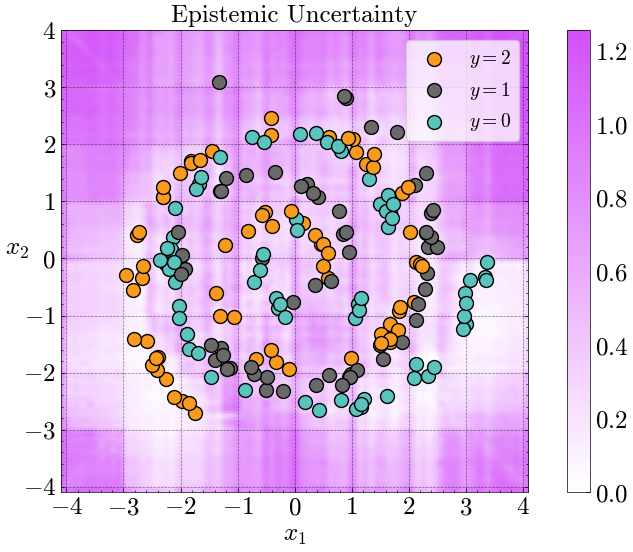

In [12]:
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('white_to_C5', ['white', brighter_colour('C5',0.5)])

fig, ax = plt.subplots(figsize=(10, 6))
epistemic_uncertainty = results_df["max_Ve"].values.reshape(feature_lengths).T
cax = ax.matshow(zoom(epistemic_uncertainty, ZOOM_LEVEL), origin="lower", extent=extents ,cmap=custom_cmap, vmin=0)
cbar = fig.colorbar(cax)

ax.xaxis.set_ticks_position('bottom')

ax.set_title("Epistemic Uncertainty")

ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$", rotation=0)

label_0_seen = False
label_1_seen = False
label_2_seen = False
for i, row in D_data.iterrows():

    if row['label'] == 0:
        if not label_0_seen:
            label_0_seen = True
            label_string = r'$y=0$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C2', edgecolor='black', s=100, alpha=1, label=label_string)
    if row['label'] == 1:
        if not label_1_seen:
            label_1_seen = True
            label_string = r'$y=1$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C3', edgecolor='black', s=100, alpha=1, label=label_string)
    if row['label'] == 2:
        if not label_2_seen:
            label_2_seen = True
            label_string = r'$y=2$'
        else:
            label_string = None
        ax.scatter(row['x1'], row['x2'], c='C4', edgecolor='black', s=100, alpha=1, label=label_string)

ax.legend(framealpha=0.75)


### Prediction Visualisations

#### 2 Class Prediction Visualisation

In [13]:
if NUMBER_OF_CLASSES == 2:
    custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('white_to_C3', ['white', 'C3'])

    fig, ax = plt.subplots(figsize=(10, 6))
    epistemic_uncertainty = results_df["p(y=1|x,D)"].values.reshape(feature_lengths).T
    cax = ax.matshow(zoom(epistemic_uncertainty, ZOOM_LEVEL), origin="lower", extent=extents ,cmap=custom_cmap, vmin=0)

    cbar = fig.colorbar(cax)

    ax.xaxis.set_ticks_position('bottom')

    ax.set_title(r"Probability $p(y=1|x,\mathcal{D})$")

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$", rotation=0)

    label_0_seen = False
    label_1_seen = False
    label_2_seen = False
    for i, row in D_data.iterrows():

        if row['label'] == 0:
            if not label_0_seen:
                label_0_seen = True
                label_string = r'$y=0$'
            else:
                label_string = None
            ax.scatter(row['x1'], row['x2'], c='C2', edgecolor='black', s=100, alpha=1, label=label_string)
        if row['label'] == 1:
            if not label_1_seen:
                label_1_seen = True
                label_string = r'$y=1$'
            else:
                label_string = None
            ax.scatter(row['x1'], row['x2'], c='C3', edgecolor='black', s=100, alpha=1, label=label_string)
        if row['label'] == 2:
            if not label_2_seen:
                label_2_seen = True
                label_string = r'$y=2$'
            else:
                label_string = None
            ax.scatter(row['x1'], row['x2'], c='C4', edgecolor='black', s=100, alpha=1, label=label_string)

    ax.legend(framealpha=0.75)
else:
    print("Plots only for binary classification")


Plots only for binary classification


#### 3 Class Prediction Visualisation

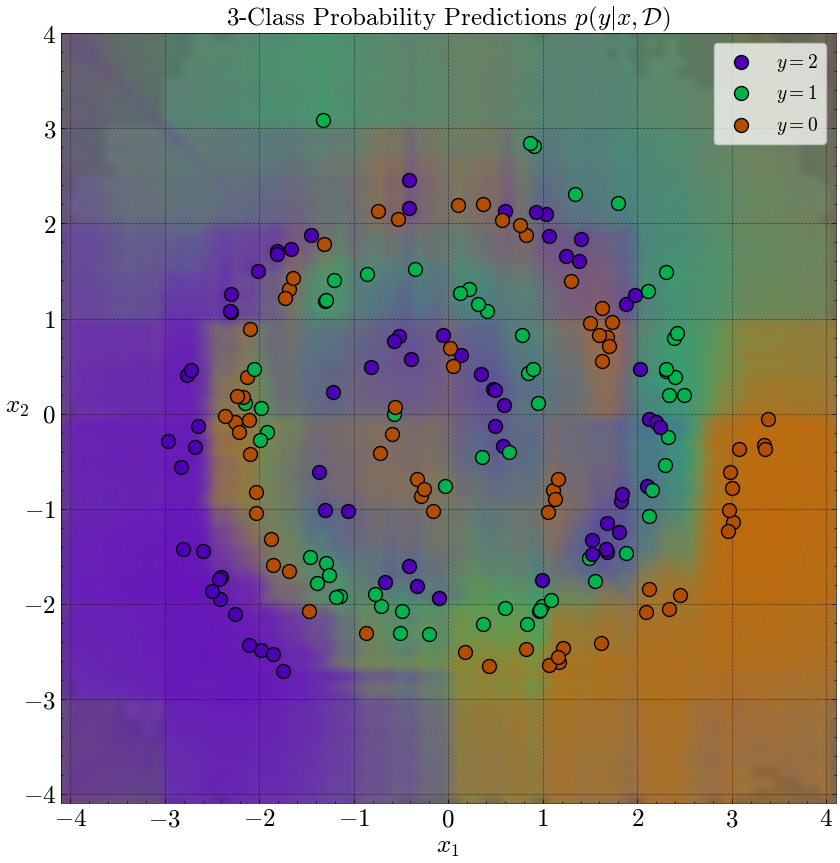

In [14]:
if NUMBER_OF_CLASSES == 3:
    fig, ax = plt.subplots(figsize=(10, 10))
    custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('white_to_C3', ['white', 'C3'])
    probability_0 = zoom(results_df["p(y=0|x,D)"].values.reshape(feature_lengths).T, ZOOM_LEVEL)
    probability_1 = zoom(results_df["p(y=1|x,D)"].values.reshape(feature_lengths).T, ZOOM_LEVEL)
    probability_2 = zoom(results_df["p(y=2|x,D)"].values.reshape(feature_lengths).T, ZOOM_LEVEL)

    colour_0 = np.array([0.7, 0.3, 0])
    colour_1 = np.array([0, 0.7, 0.3])
    colour_2 = np.array([0.3, 0, 0.7])

    colour_prob_0 = colour_combine(probability_0, colour_0)
    colour_prob_1 = colour_combine(probability_1, colour_1)
    colour_prob_2 = colour_combine(probability_2, colour_2)

    colour_sum = colour_prob_0 + colour_prob_1 + colour_prob_2
    
    ax.imshow(colour_sum**(0.75), origin="lower", extent=extents, aspect='auto', vmin=0, vmax=1)

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$", rotation=0)

    ax.xaxis.set_ticks_position('bottom')

    ax.set_title(r"3-Class Probability Predictions $p(y|x,\mathcal{D})$")

    label_0_seen = False
    label_1_seen = False
    label_2_seen = False
    for i, row in D_data.iterrows():

        if row['label'] == 0:
            if not label_0_seen:
                label_0_seen = True
                label_string = r'$y=0$'
            else:
                label_string = None
            ax.scatter(row['x1'], row['x2'], color=colour_0, edgecolor='black', s=100, alpha=1, label=label_string)
        if row['label'] == 1:
            if not label_1_seen:
                label_1_seen = True
                label_string = r'$y=1$'
            else:
                label_string = None
            ax.scatter(row['x1'], row['x2'], color=colour_1, edgecolor='black', s=100, alpha=1, label=label_string)
        if row['label'] == 2:
            if not label_2_seen:
                label_2_seen = True
                label_string = r'$y=2$'
            else:
                label_string = None
            ax.scatter(row['x1'], row['x2'], color=colour_2, edgecolor='black', s=100, alpha=1, label=label_string)
            
    plt.legend(framealpha=0.75)
else:
    print("Plots only for 3-class classification")